In [170]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Should be >=0.3.20 for `jax.debug` package
print(jax.__version__)


# def fori_loop(lower, upper, body_fun, init_val):
#     val = init_val
#     for i in range(lower, upper):
#         val = body_fun(i, val)
#     return val


# def while_loop(cond_fun, body_fun, init_val):
#     val = init_val
#     while cond_fun(val):
#         val = body_fun(val)
#     return val

from jax.lax import fori_loop, while_loop

0.3.20


In [171]:
tau_syn = 1e-2
tau_mem = 5e-3

tau_mem_inv = 1.0 / tau_mem
tau_syn_inv = 1.0 / tau_syn

A = np.array([[-tau_mem_inv, tau_mem_inv], [0,-tau_syn_inv]])

def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

dynamics = partial(f, A)
batched_dynamics = jax.vmap(dynamics, in_axes=(0, None))

In [172]:
y0 = np.array([0.0, 1.0])
xs = np.arange(0, 0.1, 1e-4)
ys = jax.vmap(partial(dynamics, y0))(xs)

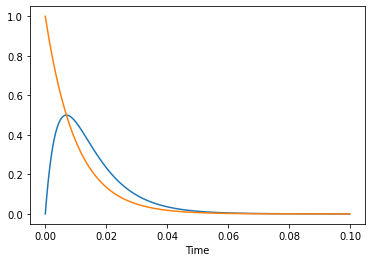

In [173]:
plt.xlabel('Time')
plt.plot(xs, ys)

In order to determine whether any jump had occured it is sufficient to focus on a given time interval $[t_k, t_{k+1}]$, we can then consider a jump condition $j$, for example one that is affine
$$j(t) = P y(t) - b$$
and do a root finding procedure on this interval.

In [174]:
# c.f.: https://github.com/google/jax/issues/8744
def newton(f, y0, x0):
  """Newton's method for root-finding."""
  initial_state = (0, x0)

  def cond(state):
    it, x = state
    return (it < 10)

  def body(state):
    it, x = state
    fx, dfx = f(y0, x), jax.grad(f, argnums=1)(y0, x)
    step = fx / dfx
    new_state = it + 1, x - step
    return new_state

  res = jax.lax.while_loop(
    cond,
    body,
    initial_state,
  )[1]
  return np.where(res > 0, res, np.nan)

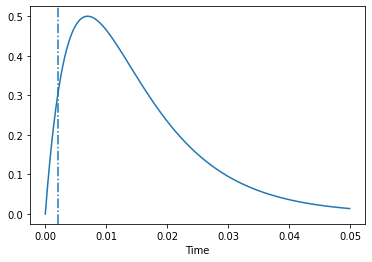

In [175]:
y0 = np.array([0.0, 1.0])
xs = np.arange(0, 0.05 ,1e-4)
v_th = 0.3


def jump_condition(dynamics, v_th, x0, t):
  return dynamics(x0, t)[0] - v_th # this implements the P y(t) - b above


jc = partial(jump_condition, dynamics, v_th)
ys = jax.vmap(partial(dynamics, y0))(xs)[:, 0]

solver = jax.jit(partial(newton, jc))

spike_time = solver(y0, 1e-4)
# %timeit solver(y0, 1e-4)

plt.xlabel('Time')
plt.plot(xs, ys)
plt.axvline(spike_time, linestyle='-.')

In [176]:
# do this for two neurons
y0 = np.array([[0.0, 1.0], [0.1, 1.0], [0.0, 0.0]])
batched_solver = jax.jit(jax.vmap(solver, in_axes=(0, None)))
spike_times = batched_solver(y0, 1e-4)
# %timeit batched_solver(y0, 1e-4)
print(spike_times)

[0.00203062 0.00137604        nan]


In [177]:
# nevative spike times return nan
solver(np.array([0.0, 0.1]), 1e-4)

DeviceArray(nan, dtype=float32)

In [178]:
def tr_equation(weights, x, spike_idx):
  x = x.at[spike_idx, 0].set(0.0)
  i_new = x[:, 1] + weights[:, spike_idx]
  return np.stack((x[:, 0], i_new), axis=1)


def step(dynamics, solver, tr_dynamics, weights, y, dt):
  t_spike = solver(y, 1e-4)

  # only integrate to next boundary
  spike_idx = np.nanargmin(t_spike)
  no_spike = spike_idx == -1
  t_dyn = jax.lax.cond(no_spike, lambda: dt, lambda: t_spike[spike_idx])
  y_minus = dynamics(y, t_dyn)

  true_fun = lambda weights, y_minus, spike_idx: y_minus
  false_fun = tr_dynamics
  args = (weights, y_minus, spike_idx)
  y_plus = jax.lax.cond(no_spike, true_fun, false_fun, *args)

  return y_plus, t_dyn, spike_idx

In [182]:
weights = np.array([[0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]) * 0.1  # type: ignore

y = np.array([[0.2, 1.0], [0.1, 1.0], [0.0, 0.0]])

step_fn = jax.jit(partial(step, batched_dynamics, batched_solver, tr_equation))
# step_fn = partial(step, batched_dynamics, batched_solver, tr_equation)
y_plus, dt, spike_idx = step_fn(weights, y, 0.1)
%timeit step_fn(weights, y, 0.1)

36.3 µs ± 615 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [183]:
def forward_integration(
      step_fn,
      weights,
      initial_state,       
      t_max, 
    ):
  def cond(state):
    it, t, y, acc = state
    return (t < t_max) & (it < 100)

  def body(state):
    it, t, y, acc = state  # t is current lower bound
   
    dt = t_max - t
    y_plus, dt_dyn, spike_idx = step_fn(weights, y, dt)
    
    # update t
    t = t + dt_dyn

    # set voltage
    acc = acc.at[it, 0].set(t)
    acc = acc.at[it, 1].set(spike_idx)

    new_state = (it+1, t, y_plus, acc)
    return new_state

  return while_loop(
    cond,
    body,
    initial_state,
  )

In [181]:
y = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 0.0]])
t_max = 20 * tau_mem
initial_state = (0, 0, y, np.zeros((100, 2)))

# run it
forward = jax.jit(partial(forward_integration, step_fn))
(it, t, y, acc) = forward(weights, initial_state, t_max)

%timeit forward(weights, initial_state, t_max)

spikes = acc[(acc[:, 0] != 0.0) & (acc[:, 1] != -1.0)]
print(f"{len(spikes)} spikes: {len(spikes[spikes[:, 1] == 0.0]), len(spikes[spikes[:, 1] == 1.0]), len(spikes[spikes[:, 1] == 2.0])}")

147 µs ± 417 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
5 spikes: (4, 1, 0)


In [211]:
# how can we define loss?
@jax.jit
def loss_fn(x):
    a = np.stack((x, np.arange(len(x))), axis=1)
    min_ix = np.argmin(np.where(a[:, 1] == 1.0, a[:, 0], np.inf))  # type: ignore
    return a[min_ix, 0]  # type: ignore

x = np.array([1.0, 2.0, 3.0])
value, grad = jax.value_and_grad(loss_fn)(x)
print(value)

2.0


In [212]:
# let's see if we can train this

def init_weights(rng, n_neurons):
  weights = jax.random.uniform(rng, (n_neurons, n_neurons))
  weights = weights.at[np.diag_indices_from(weights)].set(0.0)
  return weights


def loss(weights, input):
  target = tau_mem
  t_max = 100 * tau_mem

  initial_state = (0, 0, input, np.zeros((100, 2)))

  (it, t, input, acc) = forward(weights, initial_state, t_max)

  min_ix = np.argmin(np.where(acc[:, 1] == 1.0, acc[:, 0], np.inf))  # type: ignore
  min_spike_time = acc[min_ix, 0]  # type: ignore
  return (min_spike_time - target) ** 2


def update(weights, input):
  value, grad = jax.value_and_grad(loss)(weights, input)  # type: ignore
  weights = jax.tree_map(lambda f, df: f - 0.1 * df, weights, grad)
  return weights, value


n_neurons = 3
rng = jax.random.PRNGKey(42)
weights = init_weights(rng, n_neurons)

y = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 0.0]])
input = np.repeat(y[None, :, :], 10, axis=0)  # type: ignore
weights, loss_value = jax.lax.scan(update, weights, input)


ValueError: Reverse-mode differentiation does not work for lax.while_loop or lax.fori_loop. Try using lax.scan instead.

In [ ]:
def integrate_until(dynamics, jump_condition, recording, tr_equation, x, t, dt):
  t_until = t + dt
  while t < t_until:
    t_step = np.minimum(dt, t_until-t)
    x, t, spike_idx = integrate_to_next_jump_or_dt(dynamics, jump_condition, tr_equation, x, t, dt)
    recording = recording.at[spike_idx, 0].set(t)
  return x, t, recording

In [71]:
n_neurons = 2
v_th = 0.5
t = 0.0
dt = 1.0


def jump_condition(dynamics, v_th, x, t):
  return dynamics(x, t)[0] - v_th # this implements the P y(t) - b above

jc = partial(jump_condition, f, v_th)

def init_state(n_neurons):
  return np.zeros((n_neurons, 2))

batched_dynmaics = jax.vmap(dynamics, in_axes=(0, None))

rng = jax.random.PRNGKey(42)
rng, tr_key = jax.random.split(rng)

def init_weights(rng, n_neurons):
  return jax.random.normal(tr_key, (n_neurons, n_neurons)) * 0.2

weights = init_weights(tr_key, n_neurons)


def apply_fun(weights, input_spikes, t_end = 1):
  tr_dynamics = partial(tr_equation, weights)
  recording = np.zeros((n_neurons, 10, 2))
  x = init_state(n_neurons)
  t = 0
  for i in np.argsort(input_spikes):
    spike_time = input_spikes[i]
    assert spike_time - t > 0
    x, t, recording = integrate_until(batched_dynmaics, jump_condition, tr_dynamics, recording, x, t, spike_time - t)
    x = tr_dynamics(x, np.array([i]))

  integrate_until(batched_dynmaics, recording, v_th, x, weights, t, t_end - t)  
  return x, recording

In [72]:
# create a circular dataset
def dataset(key, batch_size, n_samples):
    r = 1
    t_late = 3 * tau_syn
    x = jax.random.uniform(key, (n_samples, batch_size, 2))
    y = np.where(x[:,:,0] - x[:,:,1] > 1, 1, 0)
    one_hot = np.array([[0.0, tau_mem], [tau_mem, 0.0]])[y]  # type: ignore
    return x * t_late, one_hot


# define a loss
def loss(recording):
    # first spike time
    recording[0, 0]
    # x, y = batch
    # t_spike = jax.vmap(apply_fn, in_axes=(None, 0))(weights, x)
    # return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))
    pass

In [73]:
rng = jax.random.PRNGKey(42)
rng, weight_rng = jax.random.split(rng)
n_neurons = 100

weights = jax.random.uniform(rng, (n_neurons, n_neurons))
x, y = dataset(rng, 10, 100)

state, recording = apply_fun(weights, x[0][0])
spikes = np.count_nonzero(recording[:, 0])
print(f"{spikes} Spike")
a = 3

TypeError: Argument '<function jump_condition at 0x29a2fa170>' of type <class 'function'> is not a valid JAX type.

In [85]:
def integrate_to_next_jump( 
    dynamics, 
    jump_condition,
    transition_equation,
    y_0
):
  jc = partial(jump_condition, dynamics, 0.3, y_0)
  spike_time = newton_with_bound(jc, 0.0, 10.0)
  y_minus = partial(dynamics, y_0)(spike_time)
  y_plus = transition_equation(y_minus)

  return (spike_time, y_minus, y_plus)
